In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import sys

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from src.evaluation import ModelComparator
from src.feature_importance import FeatureImportanceAnalyzer

In [2]:
DATA_DIR = Path('Data')
X_fourier_df = pd.read_csv(DATA_DIR / 'X' / 'X_fourier_processed.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')
data = X_fourier_df.merge(Y_df[['filename', 'VehId', 'DayNum', 'Trip', 'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km']], on=['filename', 'VehId', 'DayNum', 'Trip'], how='inner')

In [3]:
exclude_cols = ['filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)', 'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km']

veh_ids = data['VehId'].values if 'VehId' in data.columns else None

feature_cols = [col for col in data.columns 
               if col not in exclude_cols 
               and col != 'VehId'
               and col != 'filename'
               and data[col].dtype in [np.float64, np.int64]]

print(f"Features: {feature_cols}")

X = data[feature_cols].fillna(data[feature_cols].mean())

target_col = 'Y_consumption_combustion_L_per_100km'
y = data[target_col].fillna(data[target_col].mean()).values

Features: ['Absolute Load[%]_fft_fft_magnitude_0', 'Absolute Load[%]_fft_fft_frequency_0', 'Absolute Load[%]_fft_fft_magnitude_1', 'Absolute Load[%]_fft_fft_frequency_1', 'Absolute Load[%]_fft_fft_magnitude_2', 'Absolute Load[%]_fft_fft_frequency_2', 'Absolute Load[%]_fft_fft_magnitude_3', 'Absolute Load[%]_fft_fft_frequency_3', 'Absolute Load[%]_fft_fft_magnitude_4', 'Absolute Load[%]_fft_fft_frequency_4', 'Absolute Load[%]_fft_fft_energy', 'Absolute Load[%]_fft_fft_spectral_centroid', 'Air Conditioning Power[Watts]_fft_fft_magnitude_0', 'Air Conditioning Power[Watts]_fft_fft_frequency_0', 'Air Conditioning Power[Watts]_fft_fft_magnitude_1', 'Air Conditioning Power[Watts]_fft_fft_frequency_1', 'Air Conditioning Power[Watts]_fft_fft_magnitude_2', 'Air Conditioning Power[Watts]_fft_fft_frequency_2', 'Air Conditioning Power[Watts]_fft_fft_magnitude_3', 'Air Conditioning Power[Watts]_fft_fft_frequency_3', 'Air Conditioning Power[Watts]_fft_fft_magnitude_4', 'Air Conditioning Power[Watts]_

In [4]:
# Split: 80% dev (for train+val), 20% test
# dev split: 80% train, 20% val

indices = np.arange(len(X))

# dev (80%), test (20%)
idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
    indices, X, y, test_size=0.2, random_state=69
)

if veh_ids is not None:
    veh_ids_dev = veh_ids[idx_dev]
    veh_ids_test = veh_ids[idx_test]
else:
    veh_ids_dev = None
    veh_ids_test = None

print(f"Dev set: {X_dev.shape[0]} samples ({len(X_dev)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# val (20% of dev), train (80% of dev)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=69
)

if veh_ids_dev is not None:
    veh_ids_train = veh_ids_dev[:len(X_train)]
    veh_ids_val = veh_ids_dev[len(X_train):]
else:
    veh_ids_train = None
    veh_ids_val = None

print(f"Train set: {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set: {X_val.shape[0]} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

total = len(X_train) + len(X_val) + len(X_test)
print(f"\nTotal samples: {total}")
print(f"Train: {len(X_train)/total*100:.1f}% | Val: {len(X_val)/total*100:.1f}% | Test: {len(X_test)/total*100:.1f}%")

Dev set: 26009 samples (80.0%)
Test set: 6503 samples (20.0%)
Train set: 20807 samples (64.0%)
Val set: 5202 samples (16.0%)
Test set: 6503 samples (20.0%)

Total samples: 32512
Train: 64.0% | Val: 16.0% | Test: 20.0%


In [5]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
 
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]
X_train_scaled.columns = sanitized_feature_cols
X_val_scaled.columns = sanitized_feature_cols
X_test_scaled.columns = sanitized_feature_cols

print(f"Train set shape: {X_train_scaled.shape}")
print(f"Val set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.6f}")
display(X_train_scaled.head())


Train set shape: (20807, 158)
Val set shape: (5202, 158)
Test set shape: (6503, 158)
Mean: 0.000000
Std: 1.000024


,Absolute Load%_fft_fft_magnitude_0,Absolute Load%_fft_fft_frequency_0,Absolute Load%_fft_fft_magnitude_1,Absolute Load%_fft_fft_frequency_1,Absolute Load%_fft_fft_magnitude_2,Absolute Load%_fft_fft_frequency_2,Absolute Load%_fft_fft_magnitude_3,Absolute Load%_fft_fft_frequency_3,Absolute Load%_fft_fft_magnitude_4,Absolute Load%_fft_fft_frequency_4,...,Vehicle Speedkm/h_fft_fft_magnitude_2,Vehicle Speedkm/h_fft_fft_frequency_2,Vehicle Speedkm/h_fft_fft_magnitude_3,Vehicle Speedkm/h_fft_fft_frequency_3,Vehicle Speedkm/h_fft_fft_magnitude_4,Vehicle Speedkm/h_fft_fft_frequency_4,Vehicle Speedkm/h_fft_fft_energy,Vehicle Speedkm/h_fft_fft_spectral_centroid,Vehicle_Class_encoded,Transmission_encoded
27613,-0.480879,1.726611,-0.409749,1.712852,-0.370556,1.698795,-0.342785,1.684383,-0.321230,1.669224,...,-0.913511,1.140711,-0.892516,1.694329,-0.862124,-0.357432,-0.326403,0.232392,-2.557636,0.505805
1529,0.094218,-0.623258,-0.070625,-0.528121,-0.036623,-0.505440,-0.017024,-0.567984,0.001979,-0.664747,...,-0.235807,0.254520,-0.106309,-0.703061,-0.015165,-0.047834,-0.271524,0.802208,0.390659,0.505805
22352,-0.123921,-0.581109,-0.176534,-0.525466,-0.156535,-0.583646,-0.188934,-0.524429,-0.213288,-0.394182,...,-0.784743,1.447053,-0.756269,-0.718624,-0.808568,1.278564,-0.326783,0.603423,0.390659,0.505805
20983,-0.480879,1.733628,-0.409749,1.727038,-0.370556,1.720295,-0.342785,1.713333,-0.321230,1.705788,...,-0.608111,0.511010,-0.776110,-0.126158,-0.785794,1.051343,-0.319330,0.269555,0.390659,0.505805
24653,-0.480879,1.738433,-0.409749,1.736751,-0.370556,1.735015,-0.342785,1.733155,-0.321230,1.730823,...,-0.261983,0.079863,-0.404322,-0.399051,-0.454390,-0.117902,-0.186727,-0.816527,0.390659,-2.637827


In [6]:
all_models = {}
all_predictions = {}
metrics_dict = {}

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.abs(y_true))) * 100 if np.all(y_true != 0) else np.nan
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# LightGBM
train_data = lgb.Dataset(X_train_scaled, label=y_train)
valid_data = lgb.Dataset(X_val_scaled, label=y_val, reference=train_data)

params = { # cross validation for hyperpam tuning pending
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'max_depth': 7,
    'verbose': -1
}

model_lgbm = lgb.train(params, train_data, num_boost_round=300, valid_sets=[valid_data])
preds_lgbm = model_lgbm.predict(X_test_scaled.values)

all_models['LightGBM'] = model_lgbm
all_predictions['LightGBM'] = preds_lgbm
metrics = calculate_metrics(y_test, preds_lgbm)
metrics_dict['LightGBM'] = metrics
print(f"LightGBM RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")


LightGBM RMSE: 1.7072, R²: 0.8896


In [7]:
# Train

# Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=69, n_jobs=-1, max_depth=15)
model_rf.fit(X_train_scaled, y_train)
preds_rf = model_rf.predict(X_test_scaled)
all_models['Random Forest'] = model_rf
all_predictions['Random Forest'] = preds_rf
metrics = calculate_metrics(y_test, preds_rf)
metrics_dict['Random Forest'] = metrics

# XGBoost
model_xgb = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=7, random_state=69, n_jobs=-1)
model_xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
preds_xgb = model_xgb.predict(X_test_scaled)
all_models['XGBoost'] = model_xgb
all_predictions['XGBoost'] = preds_xgb
metrics = calculate_metrics(y_test, preds_xgb)
metrics_dict['XGBoost'] = metrics

# Linear OLS
model_ols = LinearRegression()
model_ols.fit(X_train_scaled, y_train)
preds_ols = model_ols.predict(X_test_scaled)
all_models['Linear OLS'] = model_ols
all_predictions['Linear OLS'] = preds_ols
metrics = calculate_metrics(y_test, preds_ols)
metrics_dict['Linear OLS'] = metrics

# Linear Ridge
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)
preds_ridge = model_ridge.predict(X_test_scaled)
all_models['Linear Ridge'] = model_ridge
all_predictions['Linear Ridge'] = preds_ridge
metrics = calculate_metrics(y_test, preds_ridge)
metrics_dict['Linear Ridge'] = metrics

# Linear Lasso
model_lasso = Lasso(alpha=0.001)
model_lasso.fit(X_train_scaled, y_train)
preds_lasso = model_lasso.predict(X_test_scaled)
all_models['Linear Lasso'] = model_lasso
all_predictions['Linear Lasso'] = preds_lasso
metrics = calculate_metrics(y_test, preds_lasso)
metrics_dict['Linear Lasso'] = metrics

print(f"Models: {list(all_models.keys())}")

Models: ['LightGBM', 'Random Forest', 'XGBoost', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']


In [8]:
comparator = ModelComparator()

for model_name, predictions in all_predictions.items():
    comparator.add_model_results(model_name, y_test, predictions)

comparator.print_summary()

comparison_df = comparator.get_comparison_dataframe()
print("\nDetailed Comparison Table:")
print(comparison_df.round(6).to_string())

Path('results').mkdir(exist_ok=True)

comparison_df.to_csv('results/model_comparison.csv')

if veh_ids_test is not None:
    detailed_results = pd.DataFrame({
        'VehId': veh_ids_test,
        'Actual': y_test
    })
    
    for model_name, predictions in all_predictions.items():
        detailed_results[f'{model_name}_Pred'] = predictions
    
    detailed_results.to_csv('results/model_predictions_with_vehicles.csv', index=False)
    print(f"Detailed predictions with vehicle IDs saved to results/model_predictions_with_vehicles.csv")
    print(f"Samples: {len(detailed_results)} test vehicles")


MODEL COMPARISON SUMMARY
                   RMSE       MAE        R2  MAPE        MSE  Training Time
LightGBM       1.707235  0.839963  0.889645   inf   2.914651            0.0
Random Forest  1.969019  0.938866  0.853207   NaN   3.877036            0.0
XGBoost        1.563151  0.698056  0.907486   inf   2.443442            0.0
Linear OLS     3.440444  2.102969  0.551838   inf  11.836658            0.0
Linear Ridge   3.439657  2.102310  0.552043   inf  11.831244            0.0
Linear Lasso   3.431119  2.095797  0.554264   inf  11.772578            0.0

BEST MODELS:
  RMSE:  XGBoost (1.563151)
  MAE:   XGBoost (0.698056)
  R²:    XGBoost (0.907486)
  MAPE:  LightGBM (inf%)


Detailed Comparison Table:
                   RMSE       MAE        R2  MAPE        MSE  Training Time
LightGBM       1.707235  0.839963  0.889645   inf   2.914651            0.0
Random Forest  1.969019  0.938866  0.853207   NaN   3.877036            0.0
XGBoost        1.563151  0.698056  0.907486   inf   2.443442  

In [9]:
project_path = '/media/vanafa/1TB/Workspace/Cuatri 6/ML/TP Final'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

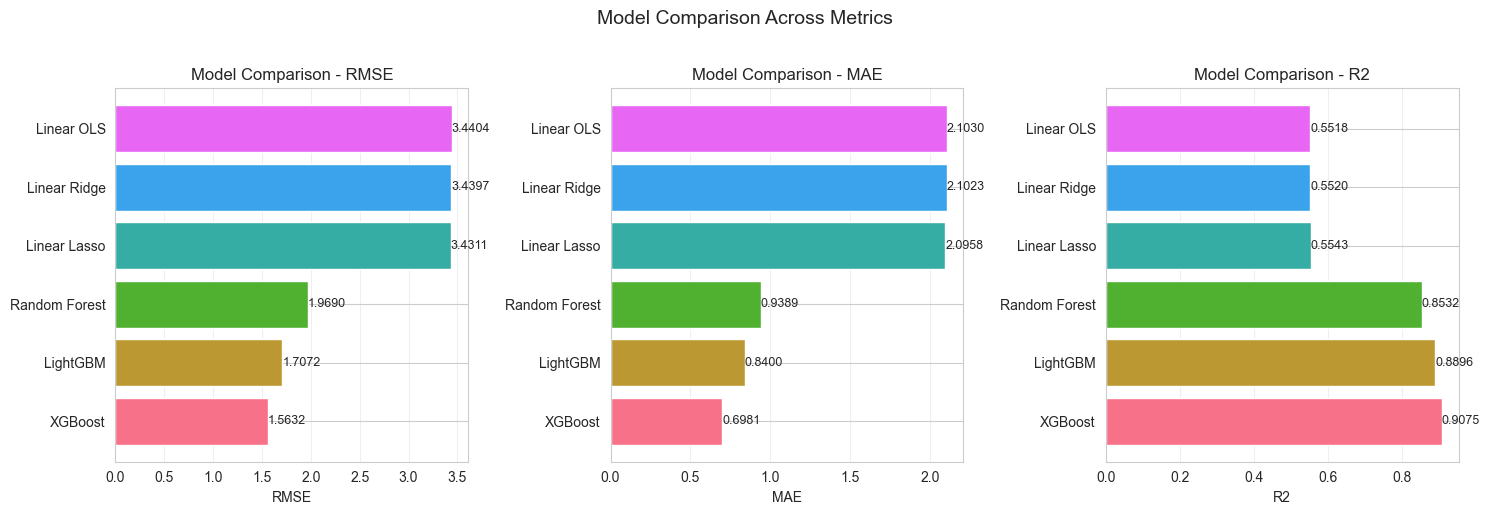

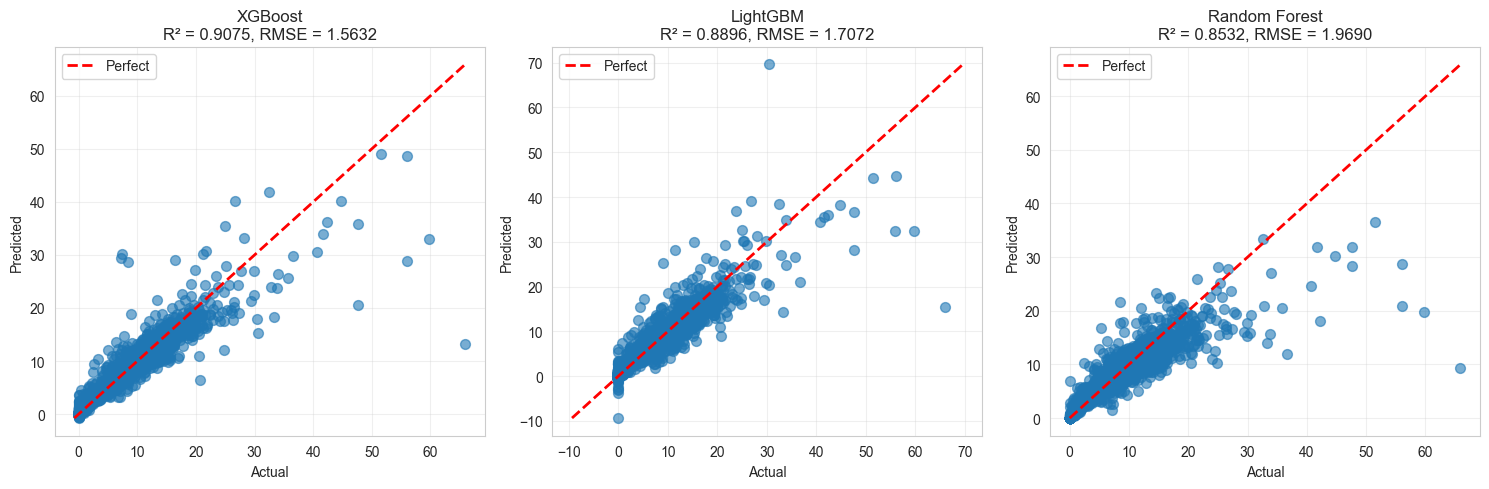

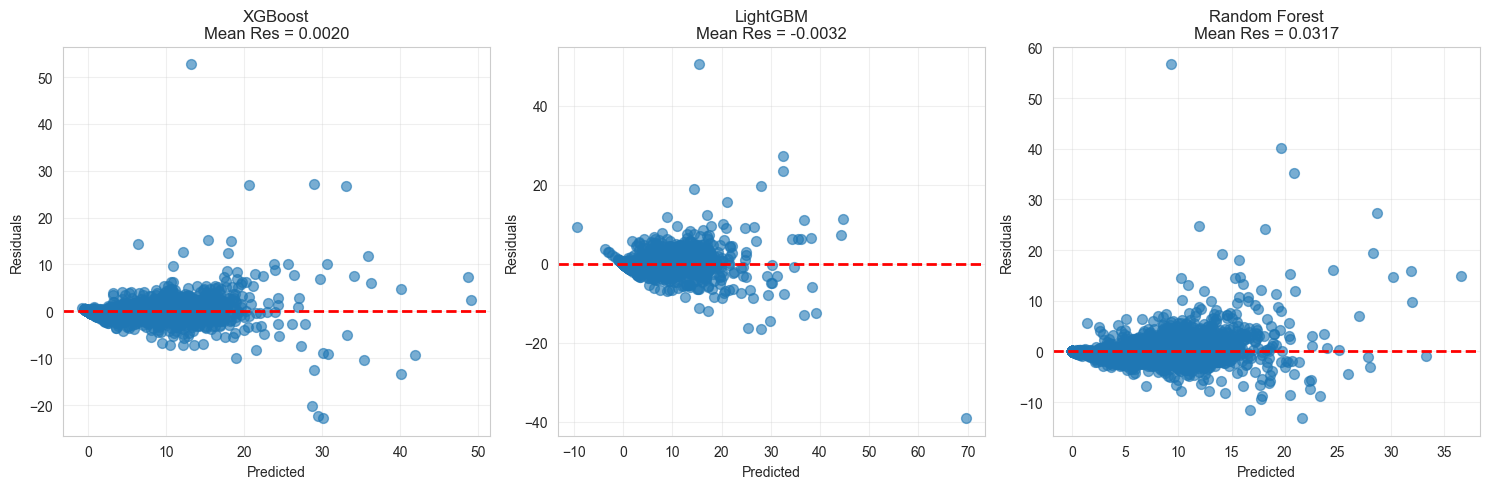

In [10]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

fig = comparator.plot_comparison(metrics=['RMSE', 'MAE', 'R2'], figsize=(15, 5))
plt.suptitle('Model Comparison Across Metrics', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

best_model_name, best_rmse = comparator.get_best_model('RMSE')

top_3_models = comparison_df['RMSE'].nsmallest(3).index.tolist()
top_3_preds = {name: all_predictions[name] for name in top_3_models}

fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    r2 = comparison_df.loc[model_name, 'R2']
    rmse = comparison_df.loc[model_name, 'RMSE']
    
    ax.scatter(y_test, preds, alpha=0.6, s=50)
    
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{model_name}\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    residuals = y_test - preds
    
    ax.scatter(preds, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model_name}\nMean Res = {residuals.mean():.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

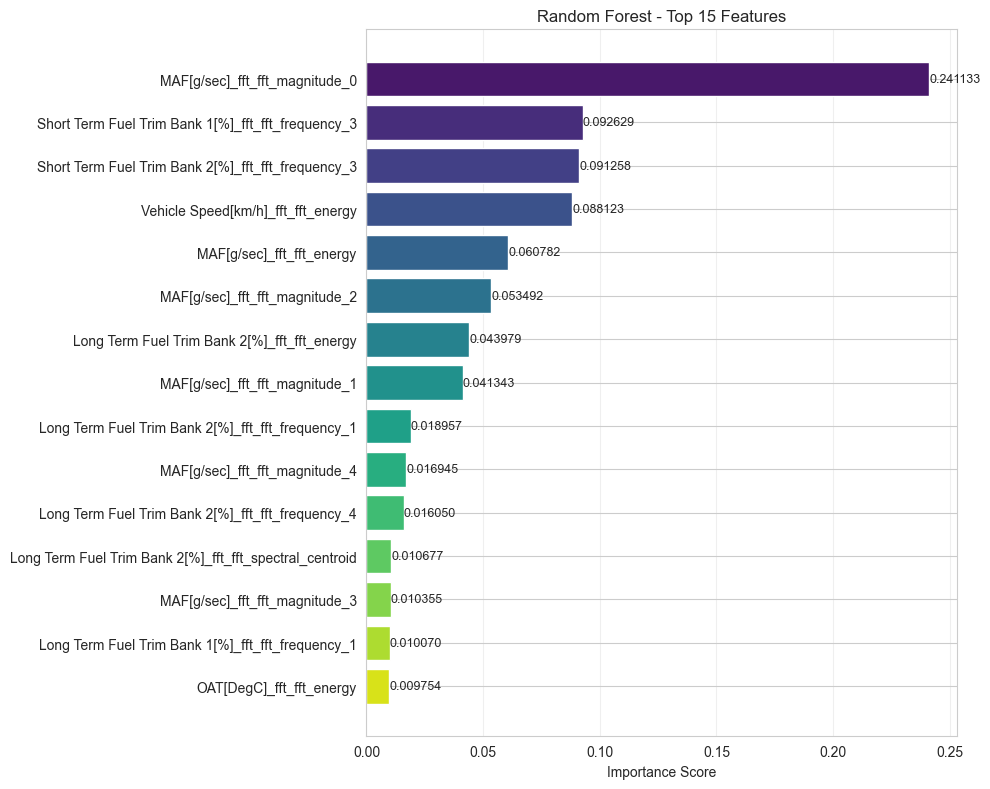

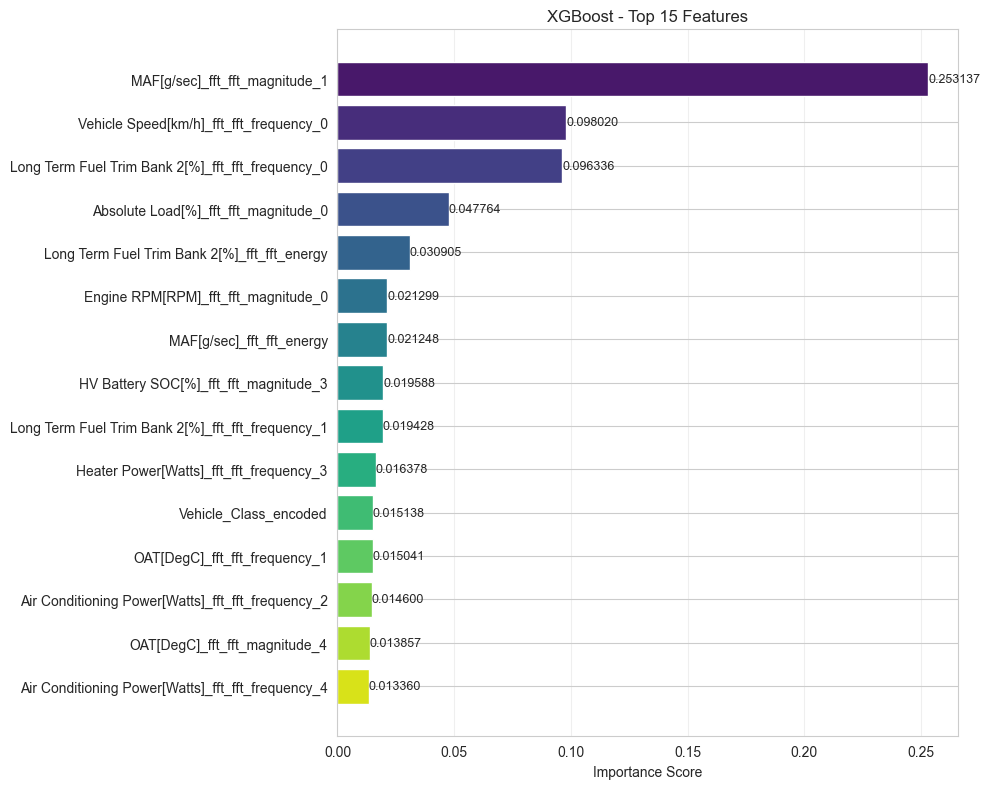

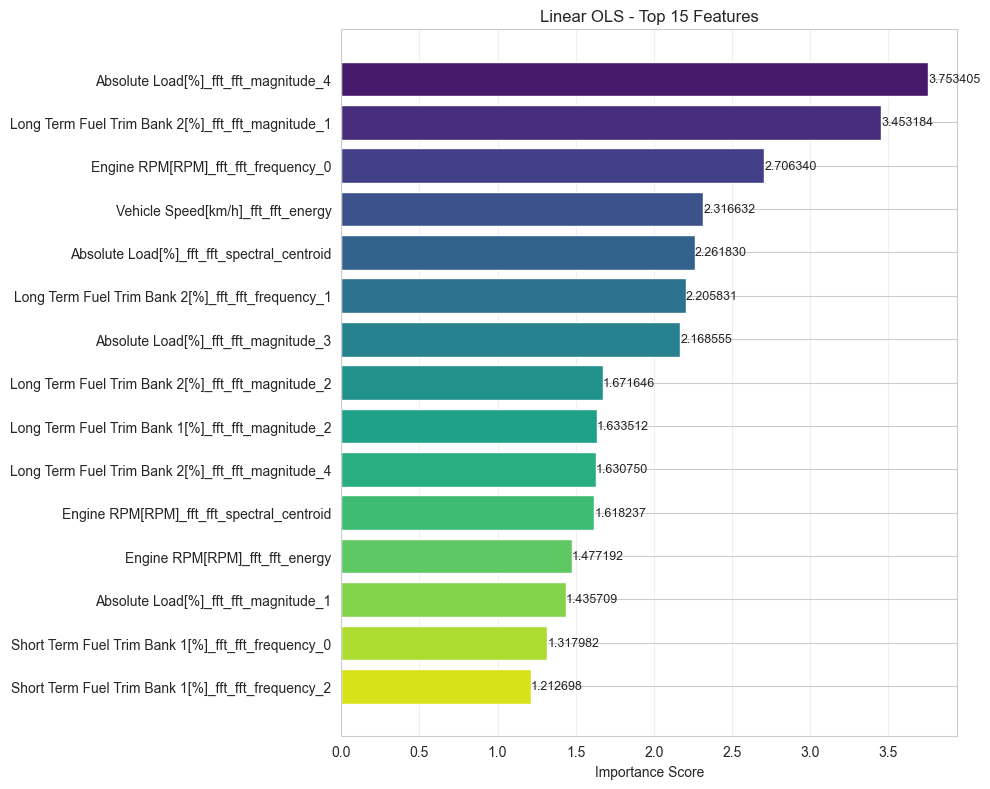

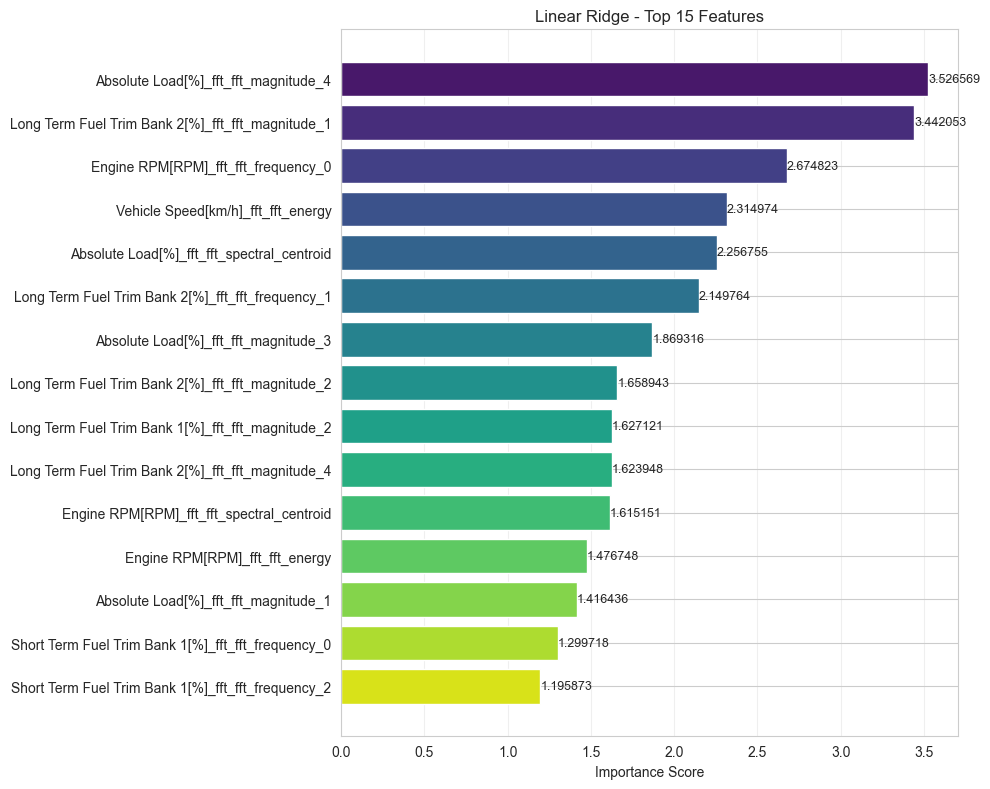

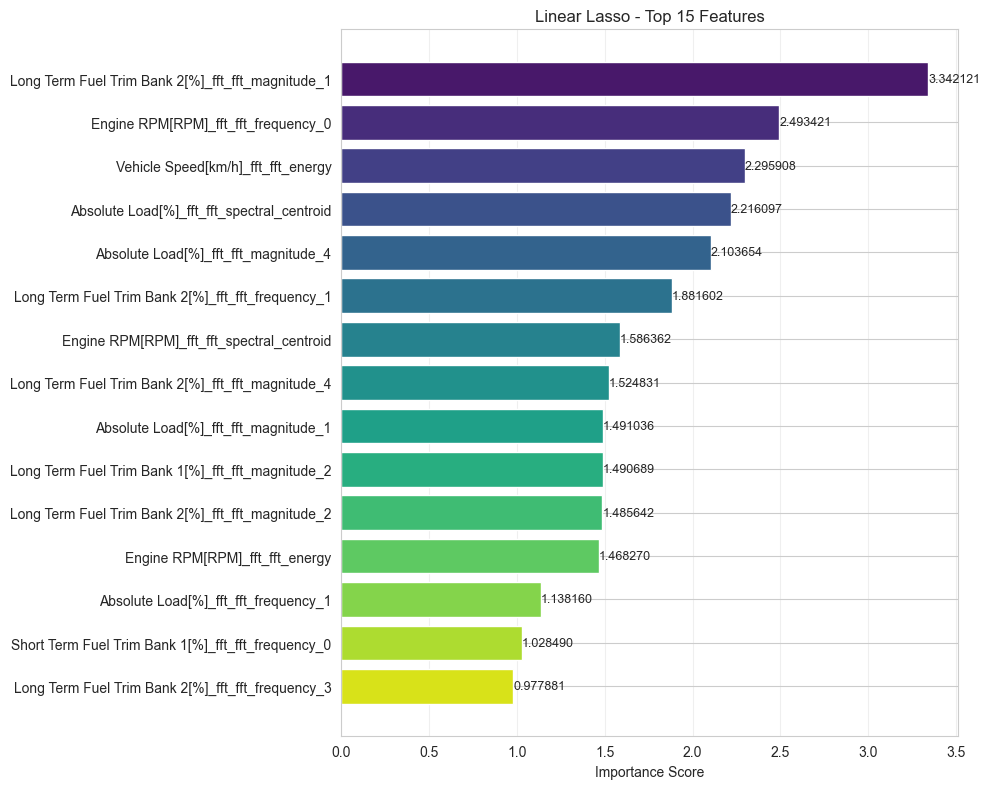

In [11]:
analyzer = FeatureImportanceAnalyzer(feature_cols)

if hasattr(all_models['Random Forest'], 'feature_importances_'):
    importance = all_models['Random Forest'].feature_importances_
    analyzer.add_importance('Random Forest', importance, 'importance')

if hasattr(all_models['XGBoost'], 'feature_importances_'):
    importance = all_models['XGBoost'].feature_importances_
    analyzer.add_importance('XGBoost', importance, 'importance')

if hasattr(all_models['LightGBM'], 'feature_importances_'):
    importance = all_models['LightGBM'].feature_importances_
    analyzer.add_importance('LightGBM', importance, 'importance')

if hasattr(all_models['Linear OLS'], 'coef_'):
    importance = np.abs(all_models['Linear OLS'].coef_)
    analyzer.add_importance('Linear OLS', importance, 'coefficient')

if hasattr(all_models['Linear Ridge'], 'coef_'):
    importance = np.abs(all_models['Linear Ridge'].coef_)
    analyzer.add_importance('Linear Ridge', importance, 'coefficient')

if hasattr(all_models['Linear Lasso'], 'coef_'):
    importance = np.abs(all_models['Linear Lasso'].coef_)
    analyzer.add_importance('Linear Lasso', importance, 'coefficient')

Path('results').mkdir(exist_ok=True)
for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'Linear OLS', 'Linear Ridge', 'Linear Lasso']:
    if model_name in analyzer.importances:
        fig = analyzer.plot_feature_importance(model_name, n=15, figsize=(10, 8))
        plt.tight_layout()
        plt.savefig(f'results/feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                   dpi=100, bbox_inches='tight')
        plt.show()

In [12]:
best_model_name, best_rmse = comparator.get_best_model('RMSE')
best_mae = comparator.get_best_model('MAE')[1]
best_r2 = comparator.get_best_model('R2')[1]

ranking = comparison_df.sort_values('RMSE')
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {model:20s} | RMSE: {row['RMSE']:10.6f} | MAE: {row['MAE']:10.6f} | R²: {row['R2']:8.6f}")


Path('models/saved_models').mkdir(parents=True, exist_ok=True)

for model_name, model in all_models.items():
    joblib.dump(model, f'models/saved_models/{model_name.replace(" ", "_")}.pkl')

joblib.dump(scaler, 'models/saved_models/feature_scaler.pkl')

1. XGBoost              | RMSE:   1.563151 | MAE:   0.698056 | R²: 0.907486
2. LightGBM             | RMSE:   1.707235 | MAE:   0.839963 | R²: 0.889645
3. Random Forest        | RMSE:   1.969019 | MAE:   0.938866 | R²: 0.853207
4. Linear Lasso         | RMSE:   3.431119 | MAE:   2.095797 | R²: 0.554264
5. Linear Ridge         | RMSE:   3.439657 | MAE:   2.102310 | R²: 0.552043
6. Linear OLS           | RMSE:   3.440444 | MAE:   2.102969 | R²: 0.551838


['models/saved_models/feature_scaler.pkl']

In [13]:
Path("models/saved_models/fourier").mkdir(parents=True, exist_ok=True)
joblib.dump(all_models[best_model_name],
            "models/saved_models/fourier/best_model.pkl")
joblib.dump(scaler,
            "models/saved_models/fourier/scaler.pkl")
print(f"✓ Best model saved: {best_model_name}")
print(f"  Location: models/saved_models/fourier/best_model.pkl")

✓ Best model saved: XGBoost
  Location: models/saved_models/fourier/best_model.pkl


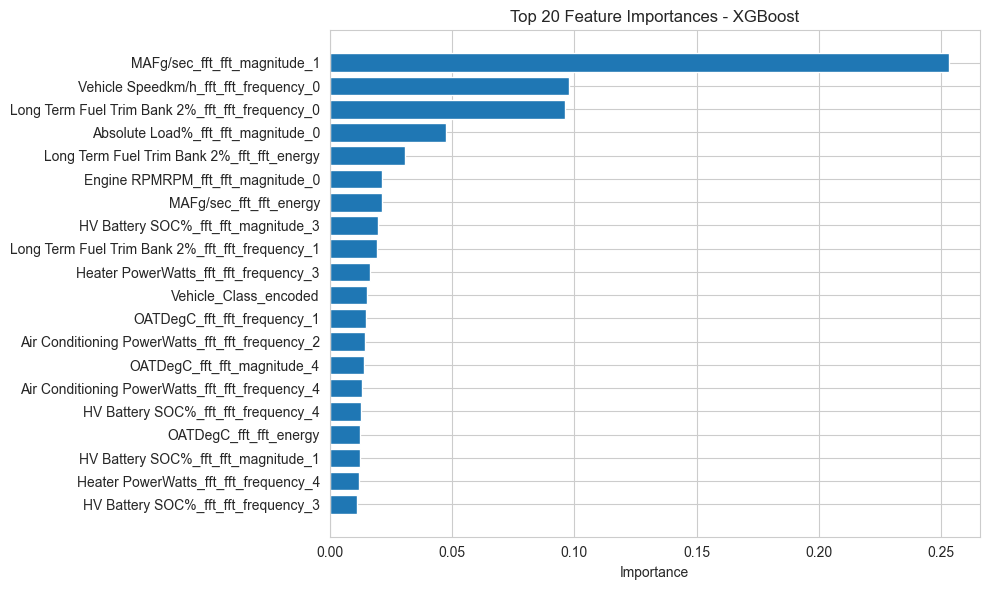

In [14]:
best_model = all_models[best_model_name]
feature_names = X_train_scaled.columns

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'feature_importance'):
    importances = best_model.feature_importance(importance_type='gain')
else:
    print(f"Modelo {best_model_name} no tiene atributo de importancia de features")
    importances = None

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(
    np.array(feature_names)[indices][:20][::-1],
    importances[indices][:20][::-1]
)
plt.title(f"Top 20 Feature Importances - {best_model_name}")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

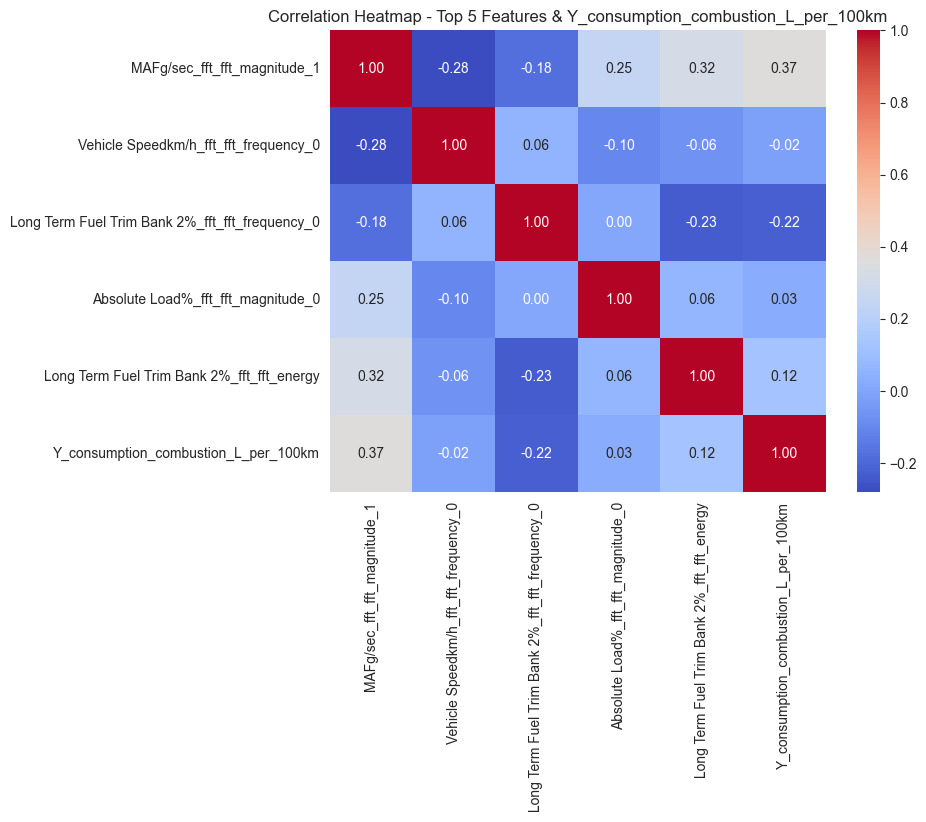

In [15]:
best_model = all_models[best_model_name]
feature_names = X_train_scaled.columns

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
elif hasattr(best_model, 'feature_importance'):
    importances = best_model.feature_importance(importance_type='gain')
else:
    print(f"Modelo {best_model_name} no tiene atributo de importancia de features")
    importances = None

if importances is not None:
    top_k = 5
    idx_sorted = np.argsort(importances)[::-1]
    top_features = feature_names[idx_sorted][:top_k]

    corr_df = pd.concat(
        [
            X_train_scaled[top_features],
            pd.Series(y_train, name=target_col, index=X_train_scaled.index),
        ],
        axis=1
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(f"Correlation Heatmap - Top {top_k} Features & {target_col}")
    plt.show()
else:
    print(f"No se pueden mostrar correlaciones para {best_model_name}")

Usando columna de aceleración: Engine RPM[RPM]_fft_fft_magnitude_0


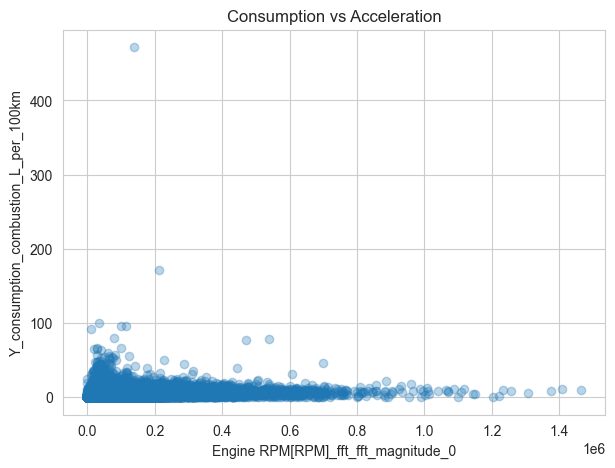

In [16]:
accel_cols = [c for c in data.columns if "rpm" in c.lower() or "epm" in c.lower()]

accel_col = accel_cols[0]
print(f"Usando columna de aceleración: {accel_col}")

plt.figure(figsize=(7, 5))
plt.scatter(data[accel_col], data[target_col], alpha=0.3)
plt.xlabel(f"{accel_col}")
plt.ylabel(target_col)
plt.title("Consumption vs Acceleration")
plt.grid(True)
plt.show()

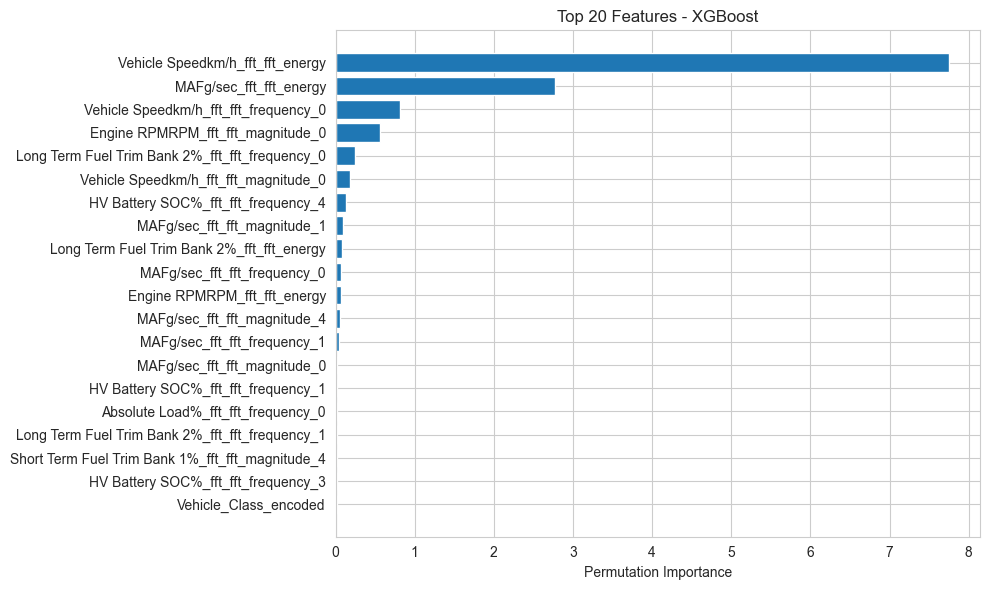

In [17]:
from sklearn.inspection import permutation_importance

best_model = all_models[best_model_name]

if hasattr(best_model, 'feature_names_in_'):
    feature_names_for_importance = best_model.feature_names_in_
    X_test_for_importance = X_test_scaled
elif hasattr(best_model, 'feature_name'):
    feature_names_for_importance = X_test_scaled.columns
    X_test_for_importance = X_test_scaled
else:
    feature_names_for_importance = X_test_scaled.columns
    X_test_for_importance = X_test_scaled

X_test_import = pd.DataFrame(
    X_test_for_importance.values,
    columns=feature_names_for_importance,
    index=X_test_for_importance.index
)

try:
    if best_model_name == 'LightGBM':
        class LGBMWrapper:
            def __init__(self, booster):
                self.booster = booster
            
            def fit(self, X, y):
                return self
            
            def predict(self, X):
                if isinstance(X, pd.DataFrame):
                    return self.booster.predict(X.values)
                return self.booster.predict(X)
        
        wrapper_model = LGBMWrapper(best_model)
        
        result = permutation_importance(
            wrapper_model,
            X_test_import,
            y_test,
            n_repeats=10,
            random_state=69,
            n_jobs=-1
        )
    else:
        result = permutation_importance(
            best_model,
            X_test_import,
            y_test,
            n_repeats=10,
            random_state=69,
            n_jobs=-1
        )

    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(
        X_test_import.columns[indices][:20][::-1],
        importances[indices][:20][::-1]
    )
    plt.xlabel("Permutation Importance")
    plt.title(f"Top 20 Features - {best_model_name}")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error al calcular permutation importance para {best_model_name}: {str(e)}")
    print("Intentando método alternativo...")
    
    if hasattr(best_model, 'feature_importance'):
        try:
            importances = best_model.feature_importance(importance_type='gain')
            indices = np.argsort(importances)[::-1]
            
            plt.figure(figsize=(10, 6))
            plt.barh(
                X_test_import.columns[indices][:20][::-1],
                importances[indices][:20][::-1]
            )
            plt.xlabel("Feature Importance (Gain)")
            plt.title(f"Top 20 Features - {best_model_name}")
            plt.tight_layout()
            plt.show()
        except Exception as e2:
            print(f"También falló el método alternativo: {str(e2)}")